In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

# --- 1. Load Data ---

In [2]:
try:
    if 'final_df' not in locals():
        final_df = pd.read_csv('csv/f1_engineered_features.csv')
    print("Engineered data loaded successfully.")
    print(f"Shape: {final_df.shape}")
except FileNotFoundError:
    print("Error: 'csv/f1_engineered_features.csv' not found. Please run the feature engineering step first.")
except Exception as e:
    print(f"Error loading data: {e}")

Engineered data loaded successfully.
Shape: (7818, 29)


# --- 2. Define Features (X) and Target (y) ---

In [3]:
TARGET_COLUMN = 'FinalPoints'

identifier_cols = ['Season', 'Round', 'EventName', 'DriverId']
target_cols = ['FinalRank', 'FinalPoints']

feature_cols = [col for col in final_df.columns if col not in identifier_cols + target_cols]

X = final_df[feature_cols + ['Season']]
y = final_df[TARGET_COLUMN]

print(f"Target variable (y): {TARGET_COLUMN}")
print(f"Number of features (X): {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")

Target variable (y): FinalPoints
Number of features (X): 23
Feature columns: ['TeamId', 'RaceCount', 'DidFinish', 'PitLaneStart', 'CumulativePoints', 'AvgPoints', 'AvgFinishPos', 'AvgGridPos', 'AvgPosGained', 'FinishRate', 'DNFCount', 'StdDevFinishPos', 'Wins', 'Podiums', 'Top10s', 'PointsLast5', 'AvgFinishLast5', 'AvgGridLast5', 'FinishRateLast5', 'DNFCountLast5', 'PrevSeasonRank', 'PrevSeasonPoints', 'PrevSeasonWins']


# --- 3. Chronological Split ---

In [4]:
TEST_SEASON = 2022

train_indices = X['Season'] < TEST_SEASON
test_indices = X['Season'] == TEST_SEASON

X_train_raw = X[train_indices].drop(columns=['Season'])
X_test_raw = X[test_indices].drop(columns=['Season'])
y_train = y[train_indices]
y_test = y[test_indices]

print(f"Training data shape (X): {X_train_raw.shape}, (y): {y_train.shape}")
print(f"Testing data shape (X): {X_test_raw.shape}, (y): {y_test.shape}")
print(f"Training seasons: {final_df[train_indices]['Season'].unique()}")
print(f"Testing season: {final_df[test_indices]['Season'].unique()}")

Training data shape (X): (4437, 23), (y): (4437,)
Testing data shape (X): (3381, 23), (y): (3381,)
Training seasons: [2020 2021]
Testing season: [2022]


# --- 4. Preprocessing Pipeline ---

In [5]:
categorical_features = ['TeamId']
numerical_features = [col for col in X_train_raw.columns if col not in categorical_features]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features count: {len(numerical_features)}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print("Fitting preprocessor on training data...")
preprocessor.fit(X_train_raw)

print("Transforming training and testing data...")
X_train_processed = preprocessor.transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

try:
    num_feature_names = numerical_features
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    processed_feature_names = num_feature_names + list(cat_feature_names)
    print(f"Total features after preprocessing: {len(processed_feature_names)}")
except Exception as e:
    processed_feature_names = None
    print(f"Could not retrieve feature names after preprocessing: {e}")


if processed_feature_names and len(processed_feature_names) == X_train_processed.shape[1]:
     X_train = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train_raw.index)
     X_test = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test_raw.index)
else:
     X_train = pd.DataFrame(X_train_processed, index=X_train_raw.index)
     X_test = pd.DataFrame(X_test_processed, index=X_test_raw.index)
     print("Warning: Could not assign column names to processed DataFrames.")


print("\n--- Preprocessing Complete ---")
print("Sample of processed training data (X_train):")
print(X_train.head())
print("\nChecking range of scaled numerical features in X_train (should be ~0 to 1):")
print(X_train[numerical_features].describe().loc[['min', 'max']])

print("\nChecking for NaNs in processed data:")
print(f"NaNs in X_train: {X_train.isnull().sum().sum()}")
print(f"NaNs in X_test: {X_test.isnull().sum().sum()}")
print(f"NaNs in y_train: {y_train.isnull().sum()}")
print(f"NaNs in y_test: {y_test.isnull().sum()}")

Categorical features: ['TeamId']
Numerical features count: 22
Fitting preprocessor on training data...
Transforming training and testing data...
Total features after preprocessing: 34

--- Preprocessing Complete ---
Sample of processed training data (X_train):
   RaceCount  DidFinish  PitLaneStart  CumulativePoints  AvgPoints  \
0        0.0        0.0           0.0               0.0        0.0   
1        0.0        0.0           0.0               0.0        0.0   
2        0.0        0.0           0.0               0.0        0.0   
3        0.0        1.0           0.0               0.0        0.0   
4        0.0        1.0           0.0               0.0        0.0   

   AvgFinishPos  AvgGridPos  AvgPosGained  FinishRate  DNFCount  ...  \
0      0.473684         0.5      0.529412         1.0       0.0  ...   
1      0.473684         0.5      0.529412         1.0       0.0  ...   
2      0.473684         0.5      0.529412         1.0       0.0  ...   
3      0.473684         0.5   

# --- 5. Initializing RandomForestRegressor Model ---

In [6]:
rf_model = RandomForestRegressor(n_estimators=10000, random_state=68, n_jobs=-1, oob_score=True, max_depth=15, min_samples_split=5, min_samples_leaf=3)

# --- 6. Training the Model ---

In [7]:
rf_model.fit(X_train, y_train)

if hasattr(rf_model, 'oob_score_') and rf_model.oob_score:
    print(f"Model Out-of-Bag (OOB) R^2 Score: {rf_model.oob_score_:.4f}")

Model Out-of-Bag (OOB) R^2 Score: 0.9967


# --- 7. Predictions ---

In [8]:
y_pred = rf_model.predict(X_test)

# --- 8. Evaluate the Model ---

In [9]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Target Variable: {TARGET_COLUMN}")
print(f"Mean Absolute Error (MAE): {mae:.2f} points")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} points")
print(f"R-squared (R²): {r2:.4f}")

Target Variable: FinalPoints
Mean Absolute Error (MAE): 51.28 points
Mean Squared Error (MSE): 5223.00
Root Mean Squared Error (RMSE): 72.27 points
R-squared (R²): 0.7107


# --- 9. Feature Importances ---

Top 20 Features:
              Feature  Importance
4           AvgPoints    0.378603
6          AvgGridPos    0.237898
19     PrevSeasonRank    0.162376
20   PrevSeasonPoints    0.083560
21     PrevSeasonWins    0.074945
5        AvgFinishPos    0.016248
29    TeamId_mercedes    0.016037
31    TeamId_red_bull    0.004169
3    CumulativePoints    0.003383
11               Wins    0.003189
14        PointsLast5    0.002860
26     TeamId_ferrari    0.002402
10    StdDevFinishPos    0.002314
24      TeamId_alpine    0.001326
7        AvgPosGained    0.001326
28     TeamId_mclaren    0.001277
0           RaceCount    0.001098
16       AvgGridLast5    0.001027
23  TeamId_alphatauri    0.000726
22        TeamId_alfa    0.000673


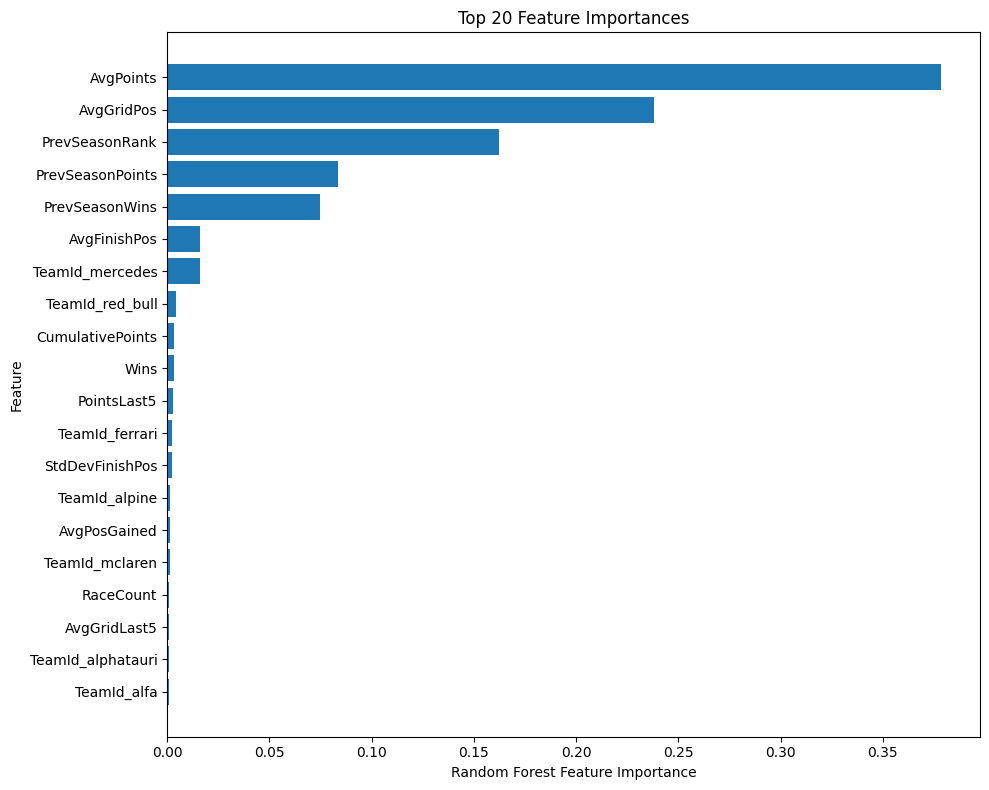

In [10]:
if 'processed_feature_names' in locals() and processed_feature_names is not None:
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': processed_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("Top 20 Features:")
    print(feature_importance_df.head(20))

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.title("Top 20 Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print("Could not display feature importances because feature names were not available.")

# --- 10. Look at Predictions vs Actuals (Sample) ---

In [13]:
print("\n--- Sample Predictions vs Actuals ---")
results_df = pd.DataFrame({'ActualPoints': y_test, 'PredictedPoints': y_pred})
results_df = final_df.loc[y_test.index, ['Season', 'Round', 'DriverId', 'TeamId']].join(results_df)
last_round = results_df['Round'].max()
print(f"Sample results for the last round (Round {last_round}) of the test season ({TEST_SEASON}):")
aggregated_results = results_df[results_df['Round'] == last_round].groupby(
    ['DriverId', 'TeamId', 'Season', 'Round']
).agg({
    'ActualPoints': 'first',
    'PredictedPoints': 'mean'
}).reset_index().sort_values(by='ActualPoints', ascending=False)
aggregated_results


--- Sample Predictions vs Actuals ---
Sample results for the last round (Round 22) of the test season (2022):


,DriverId,TeamId,Season,Round,ActualPoints,PredictedPoints
8,max_verstappen,red_bull,2022,22,454.0,352.147159
7,leclerc,ferrari,2022,22,308.0,159.903835
12,perez,red_bull,2022,22,305.0,219.051831
14,russell,mercedes,2022,22,275.0,235.025918
15,sainz,ferrari,2022,22,246.0,147.080278
4,hamilton,mercedes,2022,22,240.0,274.792709
10,norris,mclaren,2022,22,122.0,136.760490
11,ocon,alpine,2022,22,92.0,80.420609
1,alonso,alpine,2022,22,81.0,116.200946
2,bottas,alfa,2022,22,49.0,245.913049


# --- 11. Save model to a file ---

In [12]:
MODEL_ARTIFACTS_DIR = 'model_artifacts'
if not os.path.exists(MODEL_ARTIFACTS_DIR):
    os.makedirs(MODEL_ARTIFACTS_DIR)

try:
    model_path = os.path.join(MODEL_ARTIFACTS_DIR, 'trained_f1_model_1.joblib')
    joblib.dump(rf_model, model_path)
    print(f"Trained model saved to: {model_path}")

    preprocessor_path = os.path.join(MODEL_ARTIFACTS_DIR, 'fitted_f1_preprocessor_1.joblib')
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Fitted preprocessor saved to: {preprocessor_path}")

    if 'processed_feature_names' in locals() and processed_feature_names is not None:
        feature_names_path = os.path.join(MODEL_ARTIFACTS_DIR, 'processed_feature_names_1.joblib')
        joblib.dump(processed_feature_names, feature_names_path)
        print(f"Processed feature names saved to: {feature_names_path}")
    else:
        print("Warning: 'processed_feature_names' not found. Cannot save feature names.")
        print("Ensure this list is available from your preprocessing step (X_train.columns).")

    raw_feature_cols_for_prediction = X_train_raw.columns.tolist()
    raw_feature_names_path = os.path.join(MODEL_ARTIFACTS_DIR, 'raw_feature_cols_for_preprocessor_1.joblib')
    joblib.dump(raw_feature_cols_for_prediction, raw_feature_names_path)
    print(f"Raw feature columns for preprocessor input saved to: {raw_feature_names_path}")


except Exception as e:
    print(f"Error saving model artifacts: {e}")

Trained model saved to: model_artifacts\trained_f1_model_1.joblib
Fitted preprocessor saved to: model_artifacts\fitted_f1_preprocessor_1.joblib
Processed feature names saved to: model_artifacts\processed_feature_names_1.joblib
Raw feature columns for preprocessor input saved to: model_artifacts\raw_feature_cols_for_preprocessor_1.joblib
